### 5k-palms dataset with data augmentation

In [1]:
# directorios del conjuntos de datos (palmas y máscaras)
img_dir = "/Datasets/5k-palms/5k-palms/"
label_dir = "/Datasets/5k-palms/5k-palms-masks/"

In [2]:
import os

# leemos el conjunto de datos de la lista de todos los archivos
img_files = [img_dir + f for f in os.listdir(img_dir)]
label_files = [label_dir + f for f in os.listdir(label_dir)]
img_files.sort()
label_files.sort()

In [3]:
from sklearn.model_selection import train_test_split

# generamos el conjunto de datos de entrenamiento y el de validación
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
        train_test_split(img_files, label_files, test_size=0.2, random_state=7)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print(num_train_examples)
print(num_val_examples)

4310
1078


In [4]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
import functools

# definición de constantes 
img_shape = (256, 256, 3)  # debe ser divisible por 32 (maxpool2d)
batch_size = 3
epochs = 5

In [5]:
# EXPERIMENTAR: usar colores y no usar colores
def _process_pathnames(fname, label_path):
    """
    Lee las imágenes y retorna tensores de 3 canales (imagen) y 1 canal (máscara)
    """
    # imagen
    img_str = tf.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)

    # máscara
    label_img_str = tf.read_file(label_path)    
    label_img = tf.image.decode_png(label_img_str)
    
    # la máscara es binaria (2 colores) por lo que basta un canal
    label_img = label_img[:, :, 0]
    # añadimos 1 dimensión ya que la conv2d necesita como entrada [batch, height, width, channels]
    # y label_img tiene una entrada de [batch, height]
    label_img = tf.expand_dims(label_img, axis=-1)  
    return img, label_img


In [6]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """
    Aumentación de datos, desplazamiento vertical/horizontal en píxeles.
    range 1.0 significa que se podría desplazar hasta el 100% de toda la imagen (horizontal y/o vertical)
    """
    if width_shift_range or height_shift_range:
        if width_shift_range:
            # valores aleatorios que siguen una distribución uniforme
            width_shift_range = tf.random_uniform([],  # output tensor shape
                                              -width_shift_range * img_shape[1],  # 
                                              width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
        # traslación a imagen y máscara (relleno de 0s)
        output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
    return output_img, label_img


In [7]:
def flip_img(horizontal_flip, tr_img, label_img):
    """
    Aumentación de datos: voltear la imagen horizontalmente
    """
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        # condicional, ejecuta 1er lambda (verdadero) o 2ndo (falso)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
    return tr_img, label_img


In [51]:
import numpy as np
def rotate_img(rotate_flag, tr_img, label_img):
    """
    Aumentación de datos: rotar imagen
    https://stackoverflow.com/a/53855704/2692914    
    """
    if rotate_flag:        
        random_angle = tf.random_uniform([], -np.pi, np.pi)
        tr_img = tf.contrib.image.rotate(tr_img, random_angle, interpolation='BILINEAR')
        label_img = tf.contrib.image.rotate(label_img, random_angle, interpolation='BILINEAR')
#         random_angles = tf.random.uniform(shape=(tf.shape(images)[0],), minval = -np.pi / 4, maxval = np.pi / 4)

#         rotate_prob = tf.random_uniform([], 0.0, 1.0)
#         # condicional, ejecuta 1er lambda (verdadero) o 2ndo (falso)
#         tr_img, label_img = tf.cond(tf.less(flip_prob, 0.25),
#                 lambda: (tr_img, label_img)
#                 tf.cond(tf.less(flip_prob, 0.5),
#                         lambda: (tr_img, label_img),
#                         tf.cond(tf.less(flip_prob, 0.75),
                                
#                 lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
#                 )
        
#         rotate_prob = tf.random_uniform([], 0, 3, tf.int32)
#         tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
#                                     lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
#                                     lambda: (tr_img, label_img))
        
#         rotations = random.randint(0, 3)
#         print(rotations)
#         tr_img = tf.image.rot90(tr_img, rotations)
#         label_img = tf.image.rot90(label_img, rotations)
    return tr_img, label_img

In [52]:
def _augment(img,  # imagen
             label_img,  # máscara
             resize=[255, 255], 
             scale=1,  # normalizar imagen por 1./255.
             hue_delta=0,  # ajuste de matiz de color
             horizontal_flip=False,  # param flip_img
             rotate=False,
             width_shift_range=0,  # param shift_img
             height_shift_range=0):  # param shift_img
    """
    aplica aumentación a una imagen y su máscara a la vez
    la imagen original es reemplazada...
    """
    if resize is not None:
        label_img = tf.image.resize_images(label_img, resize)
        img = tf.image.resize_images(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    if horizontal_flip:
        img, label_img = flip_img(horizontal_flip, img, label_img)
    
    if rotate:
        img, label_img = rotate_img(rotate, img, label_img)
    
    if width_shift_range or height_shift_range:
        img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)

    # "normalizar" 0-1
    label_img = tf.to_float(label_img) * scale
    img = tf.to_float(img) * scale 
    return img, label_img

In [53]:
def get_baseline_dataset(filenames,  # lista de imágenes 
                         labels,  # lista de máscaras
                         preproc_fn=functools.partial(_augment),  # crear un objeto que actúa como un functor (puede ser ejecutado)
                         threads=4, 
                         batch_size=batch_size,
                         shuffle=True):

    num_x = len(filenames)
    # dataset de slices [f1,l1],[f2,l2],[f3,l3],...
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # aplicar a cada elemento del dataset la función _process_pathnames
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    # aplicar a cada elemento del dataset el "functor" preproc_fn
    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
    # randomizar
    if shuffle:
        dataset = dataset.shuffle(num_x)
    # repetir indefinidamente (count=None) y repartirla en batches
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [54]:
# creamos "functor" para conjunto de entrenamiento
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'rotate': True,
    'width_shift_range': 0.5,
    'height_shift_range': 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

# creamos "functor" para conjunto de validación
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

# creación de dataset de entrenamiento y validación
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [55]:
# creación de dataset de prueba
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

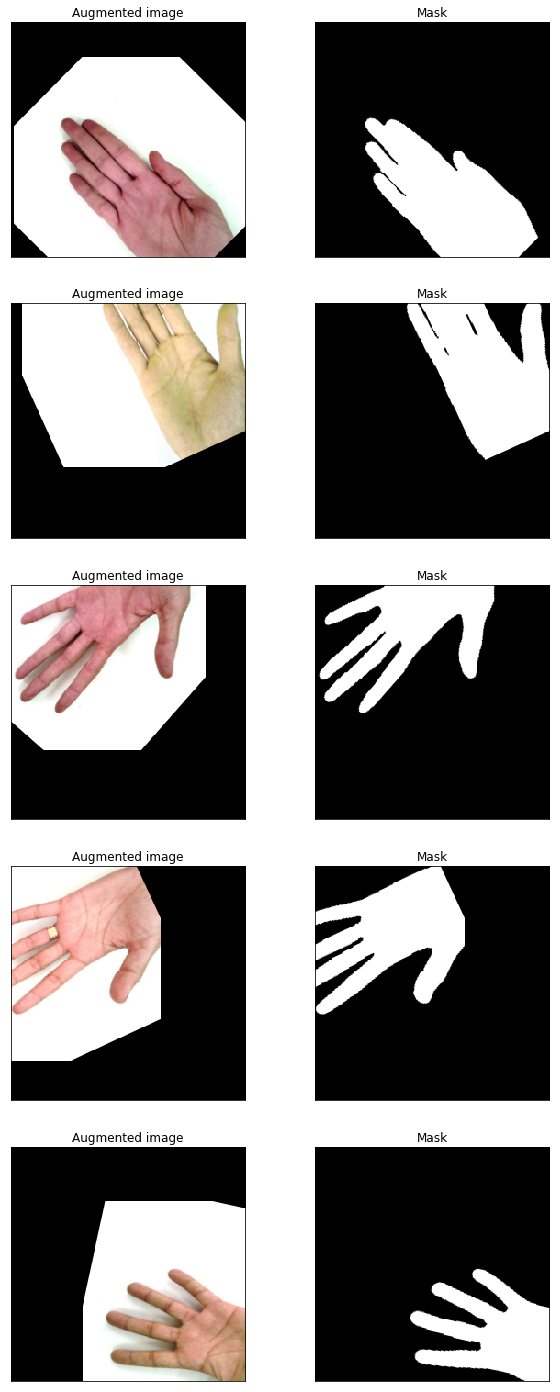

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline

display_num = 5

data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

with tf.Session() as sess: 
    plt.figure(figsize=(10, 25))
    for i in range(0, display_num*2, 2):
        batch_of_imgs, label = sess.run(next_element)
        
        img = batch_of_imgs[0]

        plt.subplot(display_num, 2, i + 1)
        plt.imshow(img)
        plt.title("Augmented image")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(display_num, 2, i + 2)
        plt.imshow(label[0, :, :, 0], cmap='gray')
        plt.title("Mask")  
        plt.xticks([])
        plt.yticks([])

    plt.show()